### Comparing kxx, kxf, and kff across pytorch and gpjax

# Pytorch implementation

In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define paramaters
sensitivity = torch.tensor([1, 1, 1, 1, 1], dtype=torch.float64)
decays = torch.tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=torch.float64)
lengthscale = torch.tensor([2.5000], dtype=torch.float64)

In [7]:
# Load variances.npy
variances = np.load('variances.npy')

In [57]:
# Kxx
PI = torch.tensor(np.pi, requires_grad=False)

class pytorch_kxx():

    def __init__(self, num_genes, variance, noisy=True):
        self.num_genes = 5
        self.variance = torch.diag(variance)
        self.noisy = noisy

        self.sensitivity = torch.tensor([1, 1, 1, 1, 1], dtype=torch.float64)
        self.decay = torch.tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=torch.float64)
        self.lengthscale = torch.tensor([2.5000], dtype=torch.float64)

    def forward(self, t1, t2, **params):
        """
        This calculates Kxx (not cross-covariance)
        t1, t2 are blocked timepoint vectors
        Parameters:
           x1 shape (num_genes*num_times)
        """
        print('forward')
        print(f'Sensitivity: {self.sensitivity}')
        print(f'Decays {self.decay}')
        print(f'Lengthscale {self.lengthscale}')

        vert_block_size = int(t1.shape[0] / self.num_genes)
        hori_block_size = int(t2.shape[0] / self.num_genes)
        t1_block, t2_block = t1[:vert_block_size], t2[:hori_block_size]
        shape = [vert_block_size * self.num_genes, hori_block_size * self.num_genes]
        K_xx = torch.zeros(shape, dtype=torch.float64)
        for j in range(self.num_genes):
            for k in range(self.num_genes):
                kxx = self.k_xx(j, k, t1_block, t2_block)
                K_xx[j * vert_block_size:(j + 1) * vert_block_size,
                     k * hori_block_size:(k + 1) * hori_block_size] = kxx
        if self.noisy:
            if hori_block_size == vert_block_size:
                jitter = 1e-4 * torch.eye(K_xx.shape[0], dtype=torch.float64)
                K_xx += jitter
                if K_xx.shape[0] == self.variance.shape[0]:
                    K_xx += self.variance
        
        print(K_xx)
        return K_xx
    

    def k_xx(self, j, k, t1_block, t2_block):
        """
        k_xx(t, t')
        t2 = t'
        Parameters:
            t1_block: tensor shape (T1,)
            t2_block: tensor shape (T2,)
        """
        t1_block = t1_block.view(-1, 1)
        t2_block = t2_block.view(1, -1)

        mult = self.sensitivity[j] * self.sensitivity[k] * self.lengthscale * 0.5 * torch.sqrt(PI)
        second_term = (self.h(k, j, t2_block, t1_block) + self.h(j, k, t1_block, t2_block))

        k_xx = mult * second_term
        #debug
        """
        print(second_term.shape)
        print(f'mult {mult}, shape: {mult.shape}')
        print(f'second term {second_term}, shape: {second_term.shape}')

        print(f'kxx shape {k_xx.shape}')

        print(f'j index {j}, k index {k}')
        print(f'time 1 {t1_block}, time 2 {t2_block}')
        print(f'sj {self.sensitivity[j]}, sk {self.sensitivity[k]}, l {self.lengthscale}, dj {self.decay[j]}, dk {self.decay[k]}')
        print(f'all sensitivity {self.sensitivity}')
        print(f'all decay {self.decay}')
        """
        return k_xx

    def h(self, k, j, t2, t1):
        l = self.lengthscale
        t_dist = t2 - t1
        multiplier = torch.exp(self.gamma(k) ** 2) / (self.decay[j] + self.decay[k])  # (1, 1)
        first_erf_term = torch.erf(t_dist / l - self.gamma(k)) + torch.erf(t1 / l + self.gamma(k))  # (T,T)
        second_erf_term = torch.erf(t2 / l - self.gamma(k)) + torch.erf(self.gamma(k))
        return multiplier * (torch.multiply(torch.exp(-self.decay[k] * t_dist), first_erf_term) - \
                             torch.multiply(torch.exp(-self.decay[k] * t2 - self.decay[j] * t1), second_erf_term))

    def gamma(self, k):
        return self.decay[k] * self.lengthscale / 2

In [29]:
# Kxf
class pytorch_kxf():
    def __init__(self, num_genes):
        self.num_genes = num_genes
        self.sensitivity = torch.tensor([1, 1, 1, 1, 1], dtype=torch.float64)
        self.decay = torch.tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=torch.float64)
        self.lengthscale = torch.tensor([2.5000], dtype=torch.float64)

    def K_xf(self, x, f):
        """
        K_xf
        Cross-covariance. Not optimised (not in marginal likelihood).
        Parameters:
            x: tensor (JT, JT) the blocked observation vector
            f: tensor (T*) the non-blocked f prediction timepoint vector
        """
        shape = [x.shape[0], f.shape[0]]
        K_xf = torch.zeros(shape, dtype=torch.float32)
        self.block_size = int(x.shape[0] / self.num_genes)  # 7
        t1_block, t2_block = x[:self.block_size].view(-1, 1), f.view(1, -1)
        for j in range(self.num_genes):
            kxf = self.k_xf(j, t1_block, t2_block)
            K_xf[j * self.block_size:(j + 1) * self.block_size] = kxf
        
        # save k_xf as global variable
        self.k_xf = K_xf
        print(K_xf)
        return K_xf

    def k_xf(self, j, x, t_f):
        l = self.lengthscale
        t_dist = x - t_f
        
        first_term = 0.5 * l * torch.sqrt(PI) * self.sensitivity[j]
        first_expon_term = torch.exp(self.gamma(j) ** 2)
        second_expon_term = torch.exp(-self.decay[j] * t_dist)
        erf_terms = torch.erf((t_dist / l) - self.gamma(j)) + torch.erf(t_f/l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms

        return kxf
    
    def gamma(self, k):
        return self.decay[k] * self.lengthscale / 2      

In [96]:
# Kff
class pytorch_kff():
    def __init__(self, noisy=True):
        self.noisy = noisy
        self.lengthscale = torch.tensor([2.5000], dtype=torch.float64)

    def K_ff(self, x1, x2):
        """Returns the RBF kernel between latent TF"""
        x1 = x1.view(-1)
        x2 = x2.view(-1)
        sq_dist = torch.square(x1.view(-1, 1)-x2)
        sq_dist = torch.div(sq_dist, 2*self.lengthscale.view((-1, 1)))
        K = torch.exp(-sq_dist)

        if self.noisy:
            if K.shape[0] == K.shape[1]:
                jitter = 1e-3 * torch.eye(x1.shape[0])
                K += jitter

        print(K)
        return K

In [22]:
train_t_pytorch = torch.tensor([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12., 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12., 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=torch.float64)
t_predict = torch.linspace(0, 13, 80, dtype=torch.float64)

variances_torch = torch.tensor(variances).reshape(-1)

In [63]:
kxx_pytorch = pytorch_kxx(5, variances_torch, noisy=True)
Kxx_torch = kxx_pytorch.forward(train_t_pytorch.view(-1,1), train_t_pytorch.view(-1,1))

forward
Sensitivity: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)
Decays tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=torch.float64)
Lengthscale tensor([2.5000], dtype=torch.float64)
tensor([[3.1382e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.7403e+00, 1.7904e+00,  ..., 4.6886e-01, 2.1099e-01,
         9.4805e-02],
        [0.0000e+00, 1.7904e+00, 3.0532e+00,  ..., 1.3148e+00, 6.0511e-01,
         2.7221e-01],
        ...,
        [0.0000e+00, 4.6886e-01, 1.3148e+00,  ..., 3.5005e+00, 2.6371e+00,
         1.3988e+00],
        [0.0000e+00, 2.1099e-01, 6.0511e-01,  ..., 2.6371e+00, 3.4420e+00,
         2.6436e+00],
        [0.0000e+00, 9.4805e-02, 2.7221e-01,  ..., 1.3988e+00, 2.6436e+00,
         3.4463e+00]], dtype=torch.float64)


In [31]:
Kxf_pytorch = pytorch_kxf(5)
Kxf_torch = Kxf_pytorch.K_xf(train_t_pytorch.view(-1,1), t_predict.view(-1,1))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0854e+00, 1.1412e+00, 1.1905e+00,  ..., 3.1407e-09, 1.7595e-09,
         9.7742e-10],
        [8.0451e-01, 8.7895e-01, 9.5488e-01,  ..., 1.8244e-06, 1.1329e-06,
         6.9758e-07],
        ...,
        [1.7630e-01, 1.9522e-01, 2.1535e-01,  ..., 1.4926e-02, 1.1346e-02,
         8.5544e-03],
        [7.9226e-02, 8.7727e-02, 9.6780e-02,  ..., 2.1989e-01, 1.8420e-01,
         1.5310e-01],
        [3.5598e-02, 3.9418e-02, 4.3486e-02,  ..., 1.0313e+00, 9.4620e-01,
         8.6192e-01]])


In [97]:
Kff_pytorch = pytorch_kff(noisy=False)
Kff_torch = Kff_pytorch.K_ff(t_predict, t_predict)

tensor([[1.0000e+00, 9.9460e-01, 9.7857e-01,  ..., 1.1342e-14, 4.8991e-15,
         2.0934e-15],
        [9.9460e-01, 1.0000e+00, 9.9460e-01,  ..., 2.5975e-14, 1.1342e-14,
         4.8991e-15],
        [9.7857e-01, 9.9460e-01, 1.0000e+00,  ..., 5.8845e-14, 2.5975e-14,
         1.1342e-14],
        ...,
        [1.1342e-14, 2.5975e-14, 5.8845e-14,  ..., 1.0000e+00, 9.9460e-01,
         9.7857e-01],
        [4.8991e-15, 1.1342e-14, 2.5975e-14,  ..., 9.9460e-01, 1.0000e+00,
         9.9460e-01],
        [2.0934e-15, 4.8991e-15, 1.1342e-14,  ..., 9.7857e-01, 9.9460e-01,
         1.0000e+00]], dtype=torch.float64)


# JAX implementation

In [88]:
import gpjax as gpx
import jax
import jax.random as jr
import jax.numpy as jnp
import tensorflow_probability.substrates.jax.bijectors as tfb

from dataclasses import dataclass, field
from jaxtyping import Float
from gpjax.base import param_field, static_field
from gpjax.kernels.stationary.utils import squared_distance

from gpjax.typing import (
    Array,
    ScalarFloat,
)

jax.config.update('jax_enable_x64', True)

In [48]:
# Kxx
@dataclass
class gpjax_kxx(gpx.kernels.AbstractKernel):
    " Test kernel for kxx"

    true_s: Float[Array, "1 5"] = static_field(jnp.array([1, 1, 1, 1, 1], dtype=jnp.float64))

    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=jnp.float64))

    l: Float[Array, "1 1"] = static_field(jnp.array([2.5000], dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        # Debug print
        """
        print(f"j: {j}")
        print(f"k: {k}")
        print(f"t1: {t1}")
        print(f"t2: {t2}")
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2

In [77]:
# Kxf

@dataclass
class gpjax_kxf(gpx.kernels.AbstractKernel):
    " Test kernel for kxf"

    true_s: Float[Array, "1 5"] = static_field(jnp.array([1, 1, 1, 1, 1], dtype=jnp.float64))

    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=jnp.float64))

    l: Float[Array, "1 1"] = static_field(jnp.array([2.5000], dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = jnp.abs(gene_xpr - latent_force)

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()
    
    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2

In [152]:
# Kff
@dataclass
class gpjax_kff(gpx.kernels.AbstractKernel):
    "Test kernel for kxf"

    l: Float[Array, "1 1"] = static_field(jnp.array([2.5000], dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        t = t[0] / self.l
        t_prime = t_prime[0] / self.l

        # NOTE: squared distance returns jnp.sum((x - y) ** 2)
        K = jnp.exp(-0.5 * squared_distance(t, t_prime))

        #print(f'K shape {K.shape}')
        #print(f'K squeezed shape {K.squeeze().shape}')
        #print(K)
        return K.squeeze()

In [153]:
@dataclass
class gpjax_kff2(gpx.kernels.AbstractKernel):
    "Test kernel for kxf"

    l: Float[Array, "1 1"] = static_field(jnp.array([2.5000], dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.l.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        #print(f'K shape {K.shape}')
        #print(f'K squeezed shape {K.squeeze().shape}')
        #print(K)
        return K.squeeze()

In [131]:
from p53_data import JAXP53_Data, dataset_3d, generate_test_times

p53_data = JAXP53_Data(replicate=0)
training_times, gene_expressions, variances = dataset_3d(p53_data)
testing_times = generate_test_times()

### Comparing Kxx

In [66]:
kxx_gpjax = gpjax_kxx()
kxx_gpjax.gram(training_times).to_dense()

Array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.72164567, 1.7903864 , ..., 0.46885754, 0.21098658,
        0.09480457],
       [0.        , 1.7903864 , 2.98299634, ..., 1.31475285, 0.60510698,
        0.27220838],
       ...,
       [0.        , 0.46885754, 1.31475285, ..., 3.39229088, 2.63712898,
        1.39875369],
       [0.        , 0.21098658, 0.60510698, ..., 2.63712898, 3.40663082,
        2.64357242],
       [0.        , 0.09480457, 0.27220838, ..., 1.39875369, 2.64357242,
        3.40952609]], dtype=float64)

In [64]:
# Compare Kxx covariance between pytorch and GPJAX
np.allclose(Kxx_torch.detach().numpy(), kxx_gpjax.gram(training_times).to_dense())

False

`Kxx` is computed differently between PyTorch and GPJax due to jitter and noise being added to calculation in Pytorch, when `kxx_pytorch` is initialised with `noisy=False` then the two covariance matrices are the same.

In [175]:
# Add noise to Kxx from GPJAX
def add_noise_kxx(kxx, variances):
    diag_var = jnp.diag(variances.reshape(-1))
    jitter = 1e-4 * jnp.eye(kxx.shape[0])

    return kxx + diag_var + jitter

Kxx_noisy = add_noise_kxx(kxx_gpjax.gram(training_times).to_dense(), variances)

np.allclose(Kxx_torch.detach().numpy(), Kxx_noisy, rtol=1e-7)

True

When the measured variance is diagnoalised and added to the `Kxx` covariance matrix as well as a jitter of `1e-4`, then the computation is the same in Pytorch and GPJax (within `1e-9`).

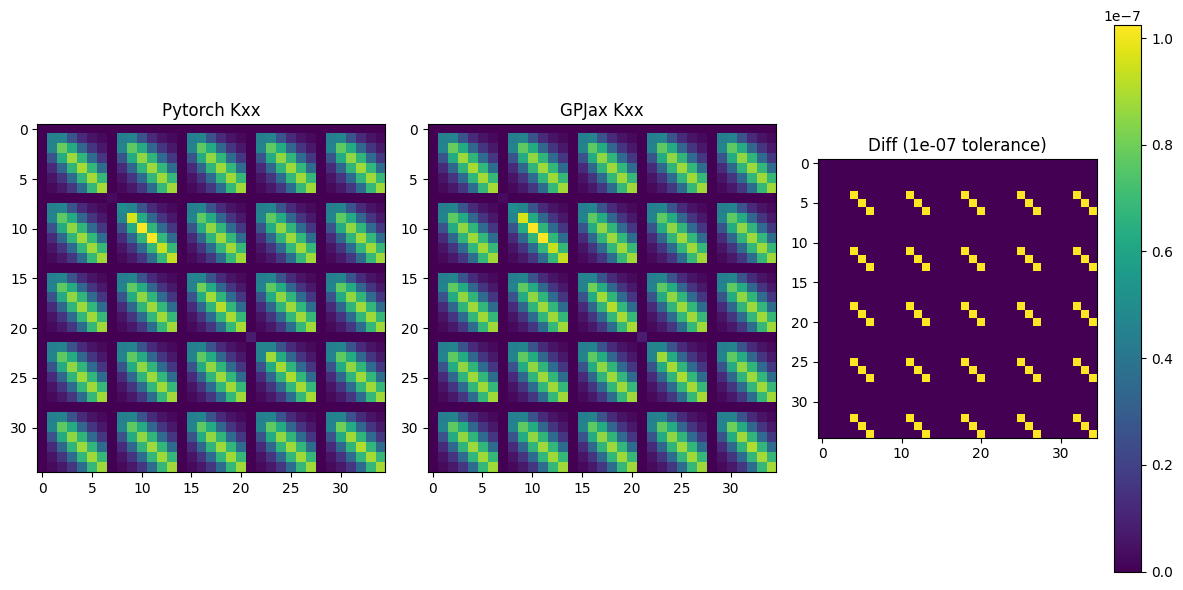

In [191]:
# Plot pytorch kxx next to GPJAX kxx
tol = 1e-7

diff_kxx = np.where(np.abs(Kxx_torch.detach().numpy() - Kxx_noisy) < tol, 0, Kxx_torch.detach().numpy() - Kxx_noisy)

plt.figure(figsize=(12, 6))
#fig, axs = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(Kxx_torch.detach().numpy())
plt.title("Pytorch Kxx")

plt.subplot(1, 3, 2)
plt.imshow(Kxx_noisy)
plt.title("GPJax Kxx")

plt.subplot(1, 3, 3)
plt.imshow(diff_kxx)
plt.title(f"Diff ({tol:.0e} tolerance)")

plt.colorbar()
plt.tight_layout()
plt.show()

### Comparing Kxf

In [81]:
# Comparing Kxf
kxf_gpjax = gpjax_kxf()
Kxf_gpjax = kxf_gpjax.cross_covariance(training_times, testing_times)
Kxf_gpjax

Array([[0.        , 0.30792584, 0.57537127, ..., 0.03580389, 0.03352307,
        0.03138754],
       [1.08541408, 1.14119253, 1.1905356 , ..., 0.07968302, 0.07460695,
        0.06985425],
       [0.80451484, 0.87894687, 0.95488369, ..., 0.17733544, 0.16603936,
        0.15546259],
       ...,
       [0.17630484, 0.1952162 , 0.21535103, ..., 0.85509555, 0.80491451,
        0.75696595],
       [0.07922583, 0.08772708, 0.09678004, ..., 1.54281993, 1.49188222,
        1.43762525],
       [0.03559848, 0.03941835, 0.04348613, ..., 1.61669951, 1.65907612,
        1.69249458]], dtype=float64)

In [83]:
np.allclose(Kxf_torch.detach().numpy(), Kxf_gpjax, atol=1e-4)

False

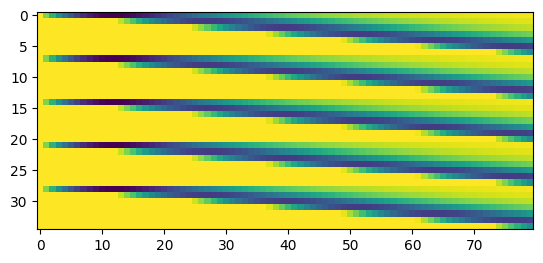

In [87]:


diff_kxf = Kxf_torch.detach().numpy() - Kxf_gpjax

plt.imshow(diff_kxf)

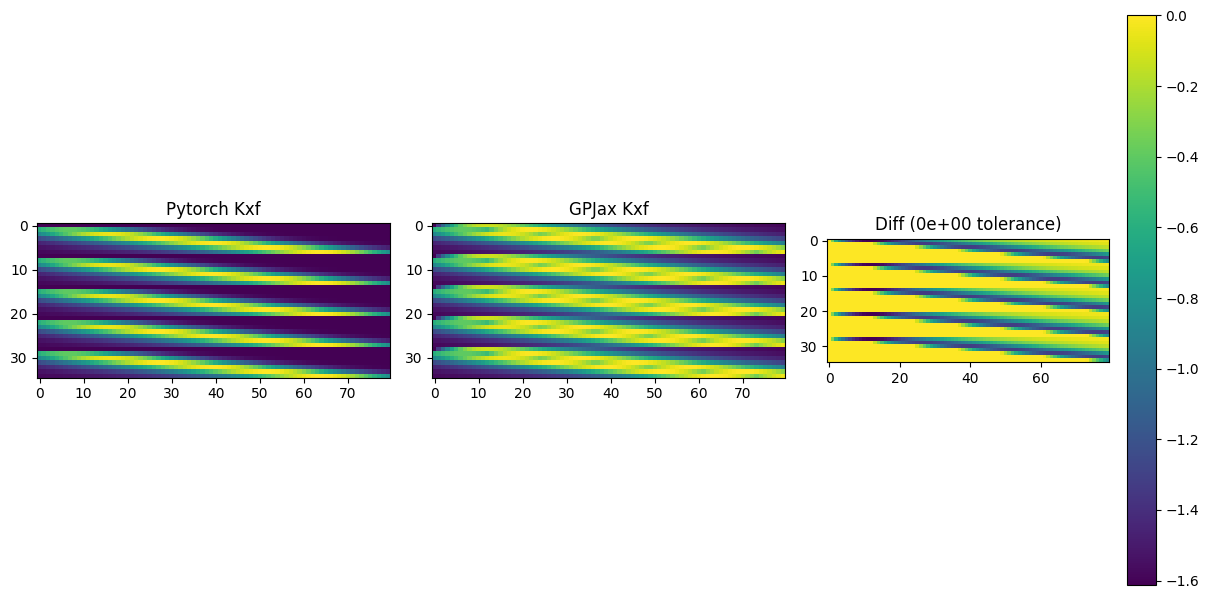

In [208]:
# Plot pytorch kxf next to GPJAX kxf
tol_kxf = 0

#diff_kxx = np.where(np.abs(Kxx_torch.detach().numpy() - Kxx_noisy) < tol, 0, Kxx_torch.detach().numpy() - Kxx_noisy)

diff_kxf = np.where(np.abs(Kxf_torch.detach().numpy() - Kxf_gpjax) < tol_kxf, 0, Kxf_torch.detach().numpy() - Kxf_gpjax)

plt.figure(figsize=(12, 6))
#fig, axs = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(Kxf_torch.detach().numpy())
plt.title("Pytorch Kxf")

plt.subplot(1, 3, 2)
plt.imshow(Kxf_gpjax)
plt.title("GPJax Kxf")

plt.subplot(1, 3, 3)
plt.imshow(diff_kxf)
plt.title(f"Diff ({tol_kxf:.0e} tolerance)")

plt.tight_layout()
plt.colorbar()
plt.show()

### Comparing kff

In [154]:
# Comparing Kff
kff_gpjax = gpjax_kff2()
Kff_gpjax = kff_gpjax.gram(testing_times).to_dense()
Kff_gpjax

Array([[1.00000000e+00, 9.94598840e-01, 9.78569767e-01, ...,
        1.13419201e-14, 4.89912589e-15, 2.09337249e-15],
       [9.94598840e-01, 1.00000000e+00, 9.94598840e-01, ...,
        2.59746955e-14, 1.13419201e-14, 4.89912589e-15],
       [9.78569767e-01, 9.94598840e-01, 1.00000000e+00, ...,
        5.88450916e-14, 2.59746955e-14, 1.13419201e-14],
       ...,
       [1.13419201e-14, 2.59746955e-14, 5.88450916e-14, ...,
        1.00000000e+00, 9.94598840e-01, 9.78569767e-01],
       [4.89912589e-15, 1.13419201e-14, 2.59746955e-14, ...,
        9.94598840e-01, 1.00000000e+00, 9.94598840e-01],
       [2.09337249e-15, 4.89912589e-15, 1.13419201e-14, ...,
        9.78569767e-01, 9.94598840e-01, 1.00000000e+00]], dtype=float64)

In [155]:
np.allclose(Kff_torch.detach().numpy(), Kff_gpjax)

True

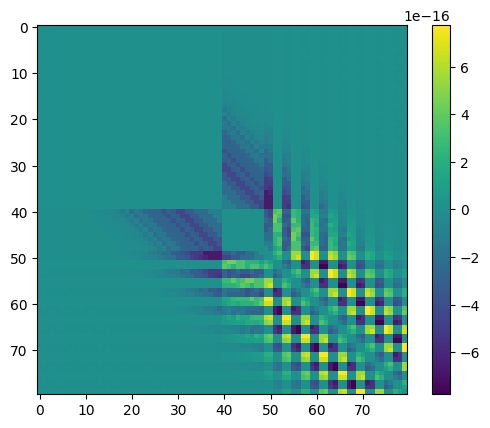

In [156]:
kff_diff = Kff_torch.detach().numpy() - Kff_gpjax

plt.imshow(kff_diff)
plt.colorbar()
plt.show()

Using the GPJAX `RBF` kernel straight out of the box gives different results to re-implementing the kernel by hand. The custom implementation computes a matrix of exponential values reflecting more complex, dimension-specific scaling and distances.

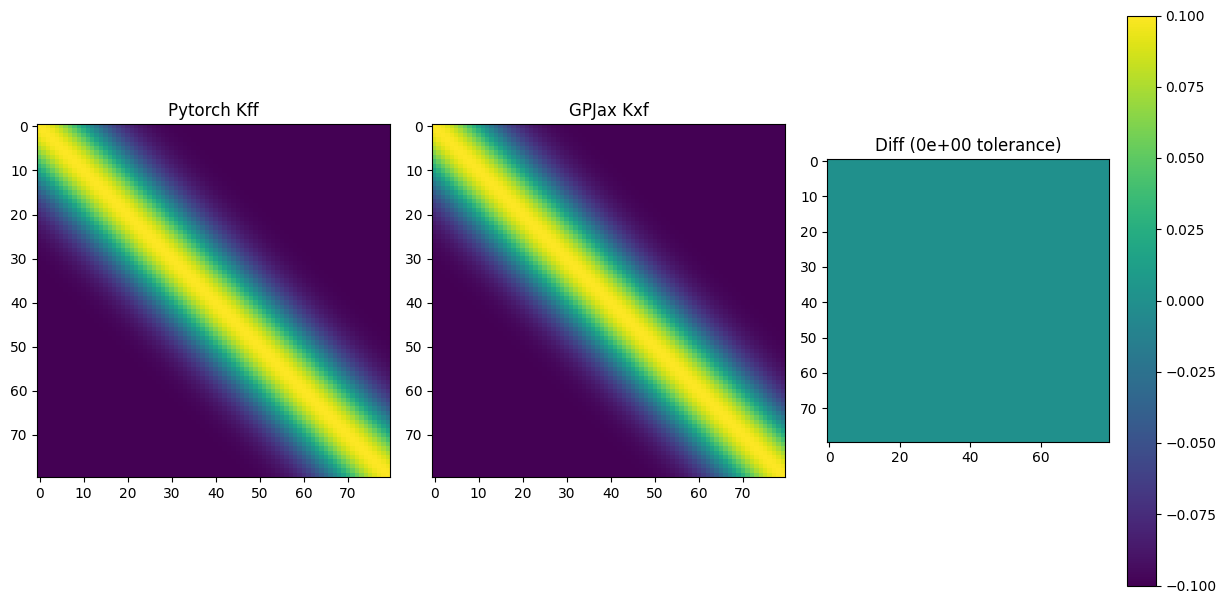

In [212]:
# Plot pytorch kff next to GPJAX kff
tol_kff = 1e-5

diff_kff = np.where(np.abs(Kff_torch.detach().numpy() - Kff_gpjax) < tol_kff, 0, Kff_torch.detach().numpy() - Kff_gpjax)

plt.figure(figsize=(12, 6))
#fig, axs = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(Kff_torch.detach().numpy())
plt.title("Pytorch Kff")

plt.subplot(1, 3, 2)
plt.imshow(Kff_gpjax)
plt.title("GPJax Kxf")

plt.subplot(1, 3, 3)
plt.imshow(diff_kff)
plt.title(f"Diff ({tol_kxf:.0e} tolerance)")

plt.tight_layout()
plt.colorbar()
plt.show()